# Validation Kernel

We should have done this as our first step, but better late than never. This simple kernel demonstrates how to run local feature validation.

In [1]:
import pandas as pd
import numpy as np
from time import time
import datetime
import lightgbm as lgb
import gc, warnings, json
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
traintr = pd.read_csv('input/train_transaction.csv.zip')
trainid = pd.read_csv('input/train_identity.csv.zip')
testtr  = pd.read_csv('input/test_transaction.csv.zip')
testid  = pd.read_csv('input/test_identity.csv.zip')

In [3]:
# For each categorical variable, we'd like to experiment with
# the count of appearances within that day's hour
# This will only work if the distributions (counts) are similar in train + test

START_DATE     = '2017-11-30'
startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
traintr['tdt']    = traintr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
traintr['thour']  = traintr.tdt.dt.hour
traintr['tmonth'] = (traintr.tdt.dt.year-2017) * 12 + traintr.tdt.dt.month
traintr['tweek'] = 52 * (traintr.tdt.dt.year-2017) + traintr.tdt.dt.weekofyear
traintr['tdoy'] = 365 * (traintr.tdt.dt.year-2017) + traintr.tdt.dt.dayofyear
traintr.tdoy -= traintr.tdoy.min() # 0-offset

testtr['tdt']    = testtr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
testtr['thour']  = testtr.tdt.dt.hour
testtr['tmonth'] = (testtr.tdt.dt.year-2017) * 12 + testtr.tdt.dt.month
testtr['tweek'] = 52 * (testtr.tdt.dt.year-2017) + testtr.tdt.dt.weekofyear
testtr['tdoy'] = 365 * (testtr.tdt.dt.year-2017) + testtr.tdt.dt.dayofyear

traintr.tdt.min()

Timestamp('2017-12-01 00:00:00')

In [4]:
traintr.groupby('tmonth').size()

tmonth
12    137321
13     92585
14     86021
15    101632
16     83655
17     89326
dtype: int64

In [5]:
traintr.tdoy.min(),traintr.tdoy.max()

(0, 181)

# Feature Evaluation Pipeline

In [6]:
SEED = 2**8+1

# TODO: Optimize
lgb_params = {
    'objective':'binary',
    'boosting_type':'gbdt',
    'metric':'auc',
    'n_jobs':-1,
    'learning_rate':0.01,
    'num_leaves': 2**5, # 5-8
    'max_depth':-1,
    'tree_learner':'serial',
    'colsample_bytree': 0.7,
    'subsample_freq':1,
    'subsample':0.7,
    'max_bin':255,
    'verbose':-1,
    'seed': SEED,
    'feature_fraction_seed': SEED + 2,
    'bagging_seed': SEED + 3,
    'drop_seed': SEED + 4,
    'data_random_seed': SEED + 5,
} 

In [14]:
def display_report(report):
    print('{} Folds Used'.format(len(report['folds'])))
    print('{} Neg DownSample Frac with {} Seed'.format(report['downsample_frac'], report['downsample_seed']))
    print('{} AVG AUC, {} STD'.format(np.round(report['avg_auc'],3), np.round(report['std_auc'],3)))
    print('{} AVG Rounds, {} Rounds'.format(report['avg_iterations'], report['std_iterations']), end='\n\n')

    features = pd.DataFrame({
        'feature': report['features'],
        'adversarial': list(report['cvs'].values()),
        'perm_import': list(report['avg_permutation_importance'].values()),
        'perm_import_std': list(report['std_permutation_importance'].values()),
    })
    features.sort_values(['perm_import','adversarial'], ascending=False, inplace=True)
    
    sns_df = pd.DataFrame({
        'feature' : sum([list(fold['permutation_importance'].keys()) for fold in results['folds']], []),
        'perm_import': sum([list(fold['permutation_importance'].values()) for fold in results['folds']], []),
        
    })
    sns_df.sort_values(['feature','perm_import'], ascending=False, inplace=True)
    
    print(report['params'])
    return features, sns_df

def compare_reports(report1, report2):
    pass

In [7]:
def run_evaluation(data, features, params, downsample_seed=None, downsample_frac=0.2, save_file_path=None):
    # NOTE: data should contain, at minimal, all train + test samples,
    # along with the isFraud column, for separation and scoring purposes.
    gc.collect()
    
    # Run evaluation and store results in a report
    # Steps:
    # 1) [x] Negative Downsample non-frauds
    # 2) [x] Run adversarial validation on features + record scores
    # 3) [x] Train on 50% overlapping folds on the trainset
    # 3b) [x] Perform permutation importance (soon to be drop importance) each fold
    # 4) [x] Aggregate and save results
    
    report = {
        'features': features,
        'params': params,
        'downsample_seed': downsample_seed,
        'downsample_frac': downsample_frac,
        'cvs': {},
        'folds': [],
        'avg_permutation_importance': {},
        'std_permutation_importance': {},
    }
    
    ######################
    print('\n# 1) [x] Negative Downsample (non-frauds)')
    if downsample_seed is None:
        selection = data.copy()
    else:
        np.random.seed(downsample_seed)
        normies = data[data.isFraud==0].index.values
        normies = np.random.choice(
            normies,
            int(data.shape[0]*downsample_frac),
            replace=False
        )
        selection = data[data.index.isin(
            # All fruds and a number of normies
            np.concatenate([normies, data[data.isFraud==1].index.values])
        )].copy()
    print(selection.shape[0], 'total train samples!')
    
    if selection.shape[0] > data.isFraud.isna().sum():
        # If we have more train samples than test samples, use all test samples
        selection_test = data[data.isFraud.isna()]
    else:
        # Use a balanced set of test samples 
        selection_test = np.random.choice(
            data[data.isFraud.isna()].index.values,
            selection.shape[0],
            replace=False
        )
        selection_test = data[data.index.isin(selection_test)]

    ######################
    print('\n# 2) [x] Run adversarial validation (CVS) on features + record scores')
    # Build CVS dataset
    cvsdata = selection.append(selection_test, sort=False)
    cvsdata.reset_index(inplace=True)
    cvsdata['which_set'] = (np.arange(cvsdata.shape[0]) >= selection.shape[0]).astype(np.uint8)
    cvsdata = cvsdata.sample(frac=1).reset_index(drop=True) # Shuffle the thing
    trn_cvs = cvsdata.index < (cvsdata.shape[0] // 2)
    for col in features:
        trn_lgb = lgb.Dataset(cvsdata[trn_cvs][[col]], label=cvsdata[trn_cvs].which_set)
        val_lgb = lgb.Dataset(cvsdata[~trn_cvs][[col]], label=cvsdata[~trn_cvs].which_set)
        clf = lgb.train(
            params,
            trn_lgb,
            valid_sets = [trn_lgb, val_lgb],
            verbose_eval = 200,
            early_stopping_rounds = 25,
            num_boost_round = 80000,
        )
        report['cvs'][col] = clf.best_score['valid_1']['auc'] - 0.5 # 0.5 = 0, best score
    del cvsdata, trn_lgb, val_lgb, trn_cvs; gc.collect()
    
    ######################
    print('\n#3) [x] Train on 50% overlapping folds on the trainset')
    for fold_, i in enumerate(range(0,57,14)):
        gc.collect()
        fold = {
            'fold_num': fold_,
            'trn_range': [i,i+90],
            'val_range': [i+90+15,i+90+15+20],
        }
        print('\nFold', fold_+1, '— Train', fold['trn_range'], '— Test', fold['val_range'])
        
        trn = selection[selection.tdoy.between(i, 90+i)]
        val = selection[selection.tdoy.between(90+i+15, 90+i+15+20)].copy()
        trn_lgb = lgb.Dataset(trn[features], label=trn.isFraud)
        val_lgb = lgb.Dataset(val[features], label=val.isFraud)
        clf = lgb.train(
            params,
            trn_lgb,
            valid_sets = [trn_lgb, val_lgb],
            verbose_eval = 200,
            early_stopping_rounds = 25,
            num_boost_round = 80000,
            #categorical_feature=[]
        )
        baseline = clf.best_score['valid_1']['auc']
        fold['auc'] = baseline
        fold['iterations'] = clf.best_iteration
        print('baseline - ', baseline)
        
        ######################
        # TODO: Repalce with Drop importance
        print('\n#3b) [x] Perform permutation importance (soon to be drop importance) each fold')
        perm = {}
        for col in features:
            backup = val[col].values.copy()
            val[col] = np.random.permutation(val[col].values)
            
            y_true = clf.predict(val[features])
            perm[col] = baseline - roc_auc_score(val.isFraud, y_true)
            val[col] = backup
        fold['permutation_importance'] = perm
        report['folds'].append(fold)
    
    ######################
    print('\n# 4) [x] Aggregate and save results')
    aucs = [fold['auc'] for fold in report['folds']]
    report['avg_auc'] = np.mean(aucs)
    report['std_auc'] = np.std(aucs)

    iterations = [fold['iterations'] for fold in report['folds']]
    report['avg_iterations'] = np.mean(iterations)
    report['std_iterations'] = np.std(iterations)

    for feature in features:
        pi = [fold['permutation_importance'][feature] for fold in report['folds']]
        report['avg_permutation_importance'][feature] = np.mean(pi)
        report['std_permutation_importance'][feature] = np.std(pi)

    if save_file_path is not None:
        with open(save_file_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, ensure_ascii=False, indent=4)
    
    gc.collect()
    return report

The function above does a few things. First, it downsamples the negative values. This was reported by a number of top-50 people on the forums, and gold medal winners in previous competitions have used this technique as well. The idea being that fraud is unique and it shouldn't matter much which non-frauds we train against, since the frauds are a distinct class and should have some level of 'difference' about them. Think outliers. This would also be a good time to mention that when we train for _submission_, we can add diversity to our models by emsembling various batches trained with different samples non-fraud values =).

The next thing the method above does is compute covariate shift scores per feature, e.g. adversarial validation. The smaller the number, the more ideal the variable. The larger the value, the worse it is—the easier it is for our model to tell train samples from test samples. If there is too much shift, we can expect our model to fail at generalizing in the private lb. We should shoot for features that have <= 0.02 CVS. If you have a really good (high permutation importance auc, low permutation importance std) feature that also has a high CVS, try engineering, transforming, windsorizing, or otherwise degrading the variable until you get it within the cutoff threshold range.

Moving on, the method above trains various overlapping folds. The folds are 90 days long, have a 15 day gap, and then use the next 20 days for validation. These windows are shifted +14 days each fold, until we get to the end of the dataset. As-Is, it doesn't matter what start date you set, because each day will still have 24hours. But if you generate features that are like holiday features, then start date becomes important.

As each fold is trained, we calculate the permutation importance measure. There's a lot of talk about what that is so I won't go into it in detail here. Just know that it's not perfect. It's 10000x better than the stalk-feature-importance measures; but to get the true feature importance, we need to run a drop importance calculation. I haven't added it here because it slows down the execution a bit (re-trains the model for each feature); but it'll probably be in our best interest to switch to that anyway.

Any feature that has a <0 permutation or drop importance should be discarded immediately. And any feature with a veri low importance, we can consider discarding recursively to test if it improves out model's score.

# Prepare Data

In [8]:
data = traintr.append(testtr, sort=False)
data.reset_index(inplace=True)

features = [
    'TransactionAmt',
    'ProductCD',
    'card1',
    'card2',
    'card3',
    'card4',
    'card5',
    'card6',
    'addr1',
    'addr2',
    'dist1',
    'dist2',
    'P_emaildomain',
    'R_emaildomain',
    'D3',
    'D1',
    'V286',
    'V100',
    'thour',
]

# LE:
for col in features:
    if data[col].dtype!='O': continue

    print('Found str', col, '... encoding!')
    mapper = {key:val for val,key in enumerate(data[col].unique())}
    data[col] = data[col].map(mapper)

Found str ProductCD ... encoding!
Found str card4 ... encoding!
Found str card6 ... encoding!
Found str P_emaildomain ... encoding!
Found str R_emaildomain ... encoding!


# Do It

In [9]:
results = run_evaluation(
    data,
    features,
    lgb_params,
    downsample_seed=1773,
    downsample_frac=0.2,
    save_file_path='./report_test.json' # persist the results to a file
)


# 1) [x] Negative Downsample (non-frauds)
240109 total train samples!

# 2) [x] Run adversarial validation (CVS) on features + record scores
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.539275	valid_1's auc: 0.531973
Early stopping, best iteration is:
[190]	training's auc: 0.53914	valid_1's auc: 0.532023
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.508451	valid_1's auc: 0.507329
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.54245	valid_1's auc: 0.53612
[400]	training's auc: 0.544714	valid_1's auc: 0.537782
Early stopping, best iteration is:
[539]	training's auc: 0.545423	valid_1's auc: 0.538444
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.545567	valid_1's auc: 0.539274
[400]	training's auc: 0.547487	valid_1's auc: 0.540255
Early stopping, best iteration is:
[393]	training's auc: 0.547493	vali

In [10]:
results

{'avg_auc': 0.8614543507199247,
 'avg_iterations': 1519.6,
 'avg_permutation_importance': {'D1': 0.032618919634878174,
  'D3': 0.028840766128488737,
  'P_emaildomain': 0.014683794128031492,
  'ProductCD': 0.030510966011392537,
  'R_emaildomain': 0.011916967840730642,
  'TransactionAmt': 0.02936864784630633,
  'V100': 0.0011276682543982063,
  'V286': 0.0003692694287690923,
  'addr1': 0.01368448981531727,
  'addr2': 0.0005995180622625273,
  'card1': 0.012887548343548372,
  'card2': 0.012663633000950058,
  'card3': 0.01350809771939796,
  'card4': 0.0012496917270147234,
  'card5': 0.004767352604428376,
  'card6': 0.010942675920093348,
  'dist1': 0.008940170807505976,
  'dist2': 0.0009479430819911317,
  'thour': 0.0038827460517223632},
 'cvs': {'D1': 0.03693164823678563,
  'D3': 0.02944289577506043,
  'P_emaildomain': 0.019130652899962963,
  'ProductCD': 0.007328661484768961,
  'R_emaildomain': 0.010783549056648911,
  'TransactionAmt': 0.0320228751326479,
  'V100': 0.005573272653573547,
  '

5 Folds Used
0.2 Neg DownSample Frac with 1773 Seed
0.861 AVG AUC, 0.005 STD
1519.6 AVG Rounds, 311.9798711455596 Rounds

{'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'n_jobs': -1, 'learning_rate': 0.01, 'num_leaves': 32, 'max_depth': -1, 'tree_learner': 'serial', 'colsample_bytree': 0.7, 'subsample_freq': 1, 'subsample': 0.7, 'max_bin': 255, 'verbose': -1, 'seed': 257, 'feature_fraction_seed': 259, 'bagging_seed': 260, 'drop_seed': 261, 'data_random_seed': 262}


/home/authman/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,feature,adversarial,perm_import,perm_import_std
15,D1,0.036932,0.032619,0.002584
1,ProductCD,0.007329,0.030511,0.017547
0,TransactionAmt,0.032023,0.029369,0.005619
14,D3,0.029443,0.028841,0.005086
12,P_emaildomain,0.019131,0.014684,0.002210
8,addr1,0.014037,0.013684,0.003896
4,card3,0.007865,0.013508,0.005105
2,card1,0.038444,0.012888,0.002212
3,card2,0.040320,0.012664,0.003641
13,R_emaildomain,0.010784,0.011917,0.003979


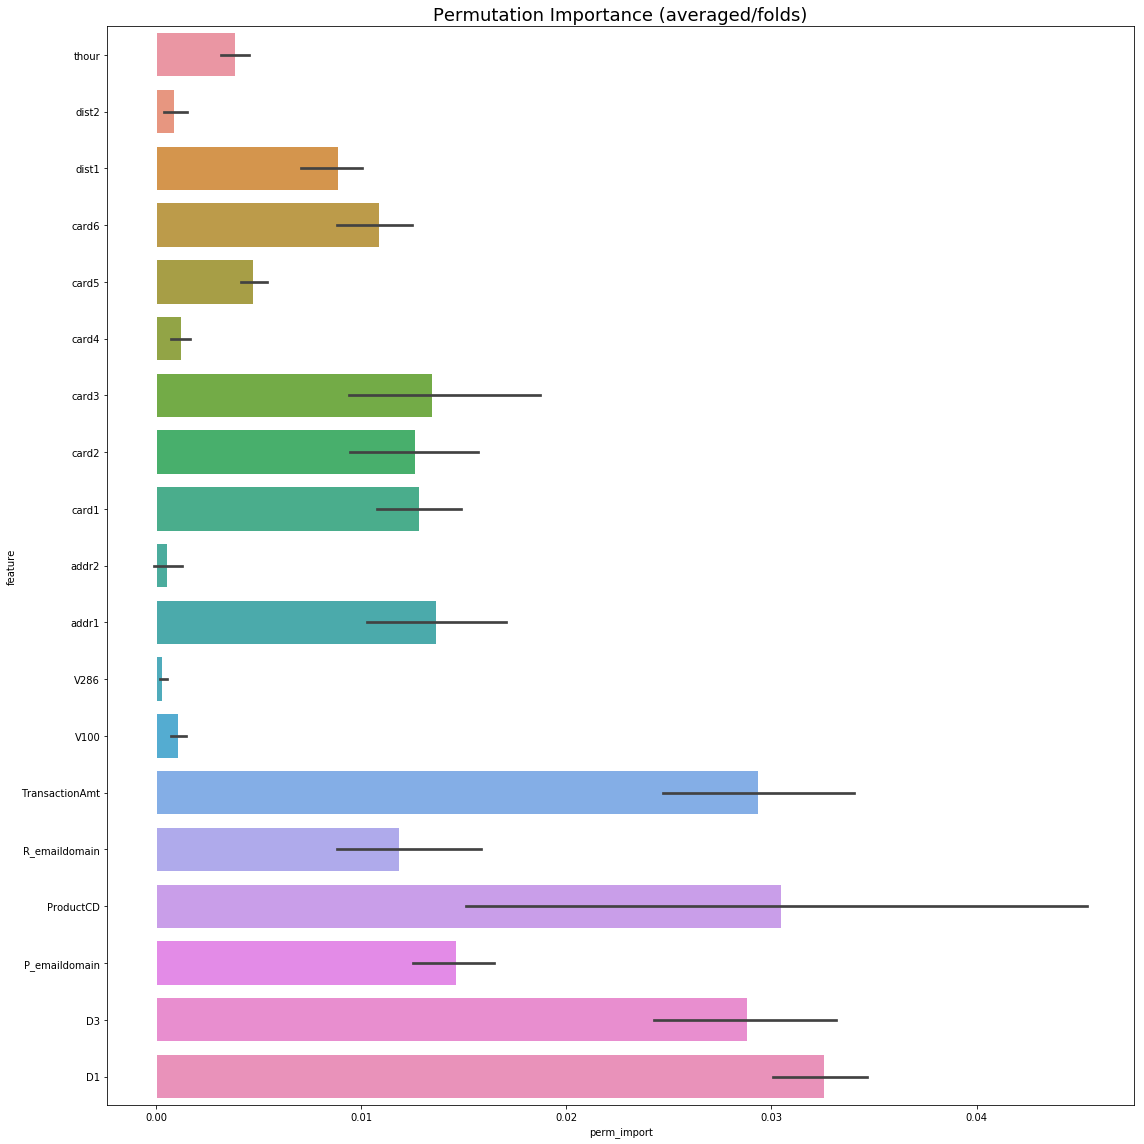

In [12]:
report, sns_features = display_report(results)

plt.figure(figsize=(16, 16))
sns.barplot(x="perm_import", y="feature", data=sns_features, edgecolor=('white'), linewidth=2)#, palette="rocket")
plt.title('Permutation Importance (averaged/folds)', fontsize=18)
plt.tight_layout()

report

If we were to look at regular gain or splits, the V columns would dominate the show. But here we accurately see they really aren't that important in the grand scheme of things. Notice how some of our variables have a very high CVS score, especially the high cardinality categorical variables, like `card2` for example. While the unique values present for card2 in train and test are very similar, their distributions shift a bit:

In [24]:
a = set(traintr.card2.unique())
b = set(testtr.card2.unique())

len(a-b), len(b-a)

(5, 2)

In [22]:
traintr.card2.value_counts().head(15)

321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
170.0    18214
194.0    16938
545.0    16355
360.0    15190
514.0    14541
174.0    11310
512.0    10126
408.0     8012
361.0     7827
100.0     7570
Name: card2, dtype: int64

In [23]:
testtr.card2.value_counts().head(15)

321.0    42796
555.0    38409
111.0    37346
490.0    32351
583.0    19700
545.0    15539
170.0    15197
194.0    14573
514.0    12684
360.0    11342
174.0    10096
512.0     9758
408.0     9148
375.0     6684
361.0     6593
Name: card2, dtype: int64

Not much we can do there. I'm not advocating removing card2 as a variable; but I am advocating we use these results to draw our attention to possible issues. So for example, the appropriate thing to do here would be to attempt the removal of card2 and observe how it affects the model's mean and std AUC. That is the ultimate 'measure'.

As we mentioned previously, any feature with a negative perm importance should be destroyed.

# TODO: Submission

I still need to flesh out the submission pipeline. Today was really brutal at work... 9 hours straight of data analysis. I'll try to get this fleshed out ASAAPPPPPPP.

Once we've decided on a subset of good engineered features to use, we must run the submission pipeline to submit. Submission pipeline is completely different from the feature validation pipeline. Rather, the sub pipeline builds many versions of a single model and merges them together. I wouldn't all this ensembling per se, since that'll happen is another, external script. But this is how we prepare our 'level-1' models for posting against Kaggle LB.

In [13]:
def submission(num_boost_rounds=0):
    # We train using fixed num_boost_rounds
    train_groups = []
    for month_start in range(4):
        # using 3x dif seeds each
        months = [12 + month_start, 12 + month_start + 1, 12 + month_start + 2]
        train_groups.append(months)
        
    # Then using double num_boost_rounds
    train_groups += [[12,13,14,15,16,17]] #dif seed 2x
    train_groups += [[12,13,14,15,16,17]] #dif seed 2x
    return train_groups

submission()

[[12, 13, 14],
 [13, 14, 15],
 [14, 15, 16],
 [15, 16, 17],
 [12, 13, 14, 15, 16, 17],
 [12, 13, 14, 15, 16, 17]]